# Demo:  Prostate Cancer Analysis with LASSO and Other Feature Selection Methods

In this demo, we illustrate the classic LASSO technique and other methods for feature selection.  You will learn to:
* Implement LASSO using the `sklearn` package
* Plot the LASSO coefficient path
* Use LASSO for feature selection
* Optimize the LASSO regularization strength using cross-validation
* Try greedy and exhaustive feature selection methods

We use a classic prostate cancer dataset from the paper:

> Stamey, Thomas A., et al. "[Prostate specific antigen in the diagnosis and treatment of adenocarcinoma of the prostate. II. Radical prostatectomy treated patients](http://www.sciencedirect.com/science/article/pii/S002253471741175X)." The Journal of Urology 141.5 (1989): 1076-1083.

In the study, the level of [prostate specific antigen](https://en.wikipedia.org/wiki/Prostate-specific_antigen) was measured in 102 men before they had a prostatectomy. Elevated values of the PSA are believed to be associated with the presence of prostate cancer and other disorders. To study this hypothesis, various features of the prostate were measured after the prostatectomy.  Data analysis can then be used to understand the relation between PSA level and prostate features.  The study is old and much more is known about PSA today.  But the analysis is typical for medical problems and illustrates the basic tools well.

The specific analysis presented in this demo is taken from the book: 

> Jerome Friedman, Trevor Hastie, and Robert Tibshirani. [Elements of statistical learning](https://www.amazon.com/exec/obidos/ASIN/0387952845/trevorhastie-20), New York: Springer series in statistics, 2001.

This book provides an excellent discussion of LASSO and other methods on this dataset.

First, we load the regular packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

seed=42 # controls randomization

## Loading the Data

Our analysis begins by downloading the data from Tibshirani's website.   

In [2]:
if True:
    # Prostrate dataset
    url = 'https://hastie.su.domains/ElemStatLearn/datasets/prostate.data'
    df = pd.read_csv(url, sep='\t', header=0)
    df = df.drop('Unnamed: 0', axis=1)   # skip the column of indices
    names = df.columns.tolist()
    names_x = names[0:8]
    name_y = names[8]
else:
    # Boston housing dataset (if you are curious to see what happens with this dataset!)
    from sklearn.datasets import load_boston
    boston = load_boston()
    df = pd.DataFrame(boston.data) # load numerical data
    df.columns = boston.feature_names
    names_x = boston.feature_names # set column names
    name_y = 'MEDV'
    df[name_y] = boston.target # define target as median house price

df.head(6)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T
5,-1.049822,3.228826,50,-1.386294,0,-1.386294,6,0,0.765468,T


In this data set, the target variable is `lpsa`, the log of the PSA. The goal is to try to predict `lpsa` from the various prostate features.

In [3]:
# Print the names of the target and predictor
print("Target variable: %s" % name_y)
print("Features:     "+str(names_x))

# Convert the dataframe values to data matrices
X0 = np.array(df[names_x])
y0 = np.array(df[name_y])

# Print the number of samples and features
nsamp = X0.shape[0]
nfeatures = X0.shape[1]
print("")
print("num samples = %d,  num features = %d" % (nsamp, nfeatures))

Target variable: lpsa
Features:     ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']

num samples = 97,  num features = 8


When performing any regularized estimate, it is critical to standardize the data.  For this purpose, we use the `sklearn` built-in `scale` command.

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xtr = scaler.fit_transform(X0)
ytr = scaler.fit_transform(y0.reshape(-1,1)).reshape(-1) # vector -> matrix and back

## LS linear regression using all features

First, we instantiate a multiple linear regression model with no regularization. Because we removed the mean of the features and targets, we know the LS intercept term will be zero and so we tell the solver not to compute it.

In [5]:
from sklearn import linear_model

# construct linear regression model
linreg = linear_model.LinearRegression(fit_intercept=False)

To predict how well any model will perform on unseen data, it is typical to use k-fold cross-validation. In this notebook, we use *repeated* k-fold cross-validation, which is k-fold CV repeated several times with different random splits.  This should give a more trustworthy result than k-fold with a single random split.  Although this is a bit more expensive than a single split, we can afford it because our dataset is relatively small.

In [6]:
import sklearn.model_selection 

# construct repeated k-fold cross-val object
nfold = 10
nrep = 5
rkf = sklearn.model_selection.RepeatedKFold(n_splits=nfold,
                                            n_repeats=nrep, random_state=seed)

# MSE for each alpha and fold value
nsplits = rkf.get_n_splits(X=Xtr, y=ytr)
RSS_ts = np.zeros(nsplits)
for ifold, ind in enumerate(rkf.split(Xtr)):
        
    # Get the training data in the split
    Itr,Its = ind
        
    X_tr = Xtr[Itr,:]
    y_tr = ytr[Itr]
    X_ts = Xtr[Its,:]
    y_ts = ytr[Its]
    
    # fit the model
    linreg.fit(X_tr,y_tr)
    
    # predict target of test data and evaluate RSS
    y_ts_pred = linreg.predict(X_ts)
    RSS_ts[ifold] = np.mean((y_ts_pred-y_ts)**2)
            
mse_cv = np.mean(RSS_ts)
mse_se = np.std(RSS_ts,ddof=1) / np.sqrt(nfold)
print("mse_cv=%f, mse_se=%f" % (mse_cv, mse_se))

mse_cv=0.403048, mse_se=0.061471


A shortcut to the above procedure is given below.  Note that it uses the `linreg` and `rkf` objects defined above.  The `scoring` option is set for compatibility with MSE, and we confirm that it returns the same output.

In [7]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(linreg, Xtr, ytr, cv=rkf, scoring='neg_mean_squared_error')
mse_cv_ls = -np.mean(scores)
print("cross-validation MSE = %f" % mse_cv_ls)

cross-validation MSE = 0.403048


##  Feature selection via exhaustive search

The optimal approach to feature selection is to fit and test a model using every possible feature subset, and choose the feature subset yielding the lowest cross-validation (CV) MSE. 

The problem with exhaustive-search is that it is very computationally costly!  For example, with $d$ features, the total number of feature subsets is $2^d$.  When $d$ is small, as in this demo, this is feasible.

Although this exhaustive-search procedure is not included in `sklearn`, we can code it ourselves with some tools from other packages.

In [8]:
from itertools import combinations

# exhaustive-search feature selection for a generic estimator, cv method, and scoring method
def best_subset_cv(estimator, X, y, max_size=8, cv=5, scoring=None):
    '''Calculates the best model of up to max_size features of X.
       estimator must have a fit and score functions.
       X must be a DataFrame.'''

    n_features = X.shape[1]
    subsets = (combinations(range(n_features), k + 1) 
               for k in range(min(n_features, max_size)))
    
    list_scores = []
    best_score = -np.inf
    for subsets_k in subsets: # for each list of subsets of the same size                
        for subset in subsets_k: # for each subset
                       
            estimator.fit(X[:, list(subset)], y)
            score = cross_val_score(estimator, X[:, list(subset)], y, cv=cv, scoring=scoring).mean()
            list_scores.append(score)
            #print("score = %f, subset = %s" % (score, str(list(subset))[1:-1]) )
            
            if score > best_score:
                best_score, best_subset = score, subset
                #print("best_score = %f, best_subset = %s" % (best_score, str(list(best_subset))[1:-1]) ) 

    return best_subset, best_score, list_scores

# perform exhaustive feature selection on the design data
subset, score, scores = best_subset_cv(linreg, Xtr, ytr, cv=rkf, 
                                        scoring='neg_mean_squared_error',
                                        max_size=nfeatures)
mse_cv_exhaustive = -score

# print selected
print("optimal features:"+str(subset))

# Print the cross-validation MSE
print("\ncross-validation MSE = %f" % mse_cv_exhaustive)

optimal features:(0, 1, 3, 4)

cross-validation MSE = 0.388072


In [9]:
# Train feature-selected LS on entire design data
linreg.fit(Xtr[:, list(subset)],ytr)

# Print the coefficients
print(" intrcpt %f" % linreg.intercept_)
for i, c in enumerate(linreg.coef_):
    print("%8s %f" % (names_x[subset[i]], c))

 intrcpt 0.000000
  lcavol 0.539614
 lweight 0.198941
    lbph 0.098786
     svi 0.253018


The above exhaustive-search results can be used as a reference when comparing other feature-selection methods.

## Feature Selection via LASSO

We now investigate using LASSO for feature selection.  The `sklearn` package has several excellent routines for this.  

### Plotting the LASSO coefficient path

To understand how LASSO works, it's insightful to plot its "coefficient path," which shows the values of its coefficents versus regularization strength `alpha`.  The `sklearn` package has a built-in routine for computing the coefficient path.

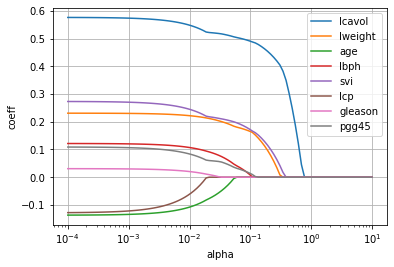

In [10]:
nalpha = 100
alphas = np.logspace(-4,1,nalpha)
alphas1, coeffs, _ = sklearn.linear_model.lasso_path(Xtr, ytr, alphas=alphas)

# Plot the paths of the coefficients
plt.semilogx(alphas1,coeffs.T)
plt.grid()
#xmin, xmax, ymin, ymax = plt.axis()
#plt.axis([xmin,np.exp(np.log(xmax)+0.25*(np.log(xmax)-np.log(xmin))),ymin,ymax])
plt.legend(names_x, loc='upper right')
plt.xlabel('alpha')
plt.ylabel('coeff')
plt.show()

The coefficient path shows two important behaviors.  First, as `alpha` increases, more coefficients are set to zero.  The order in which they go to zero is critical: the least important coefficients get turned off first.  Second, as `alpha` increases, the values of the non-zero coefficients shrink.  This is an unfortunate side-effect of LASSO's L1 regularization, because the shrinking often hurts prediction performance.

As we will see below, if one uses the LASSO-designed coefficients directly, the performance is not very good.  But, if one uses LASSO for feature selection and then least-squares to fit the values of the LASSO-selected coefficients, the results are much better.

### Tuning LASSO's regularization strength naively

With LASSO, we must choose the regularization strength `alpha`.  As we saw from the coefficient path, larger `alpha` means fewer non-zero coefficients but more shrunken coefficient values.  The question is then, how do we choose `alpha`?

We will first try a naive approach, where we use k-fold cross validation to determine the value of `alpha` that minimizes the CV-MSE of the LASSO coefficients.  That is, for each hypothesized `alpha` value, we will evaluate the MSE of the LASSO coefficients using k different training/test splits.  With large datasets, this can be time-consuming because it requires solving LASSO many times.  But this is not a problem with our dataset, which is small.

First, we implement cross-validation using two nested `for`-loops.

In [11]:
# Manual approach using 2 for-loops

# Create the LASSO model.  We use the `warm start` parameter so that the fit will start at the previous value.
# This speeds up the fitting.
lasso = linear_model.Lasso(fit_intercept=False,warm_start=True)

# Regularization values to test
nalpha = 100
alphas = np.logspace(-4,0,nalpha)

# MSE for each alpha and fold value
mse = np.zeros((nalpha,nfold*nrep))
for ifold, ind in enumerate(rkf.split(Xtr)):
    
    # Get the training data in the split
    Itr,Its = ind
    X_tr = Xtr[Itr,:]
    y_tr = ytr[Itr]
    X_ts = Xtr[Its,:]
    y_ts = ytr[Its]
    
    # Compute the lasso path for the split
    for ia, a in enumerate(alphas):
        
        # Fit the model on the training data
        lasso.alpha = a
        lasso.fit(X_tr,y_tr)
        
        # Compute the prediction error on the test data
        y_ts_pred = lasso.predict(X_ts)
        mse[ia,ifold] = np.mean((y_ts_pred-y_ts)**2)

# Compute the MSE mean over the folds and its standard error
mse_cv2 = np.mean(mse,axis=1)
mse_se2 = np.std(mse,axis=1,ddof=1) / np.sqrt(nfold)

Now, we show a shortcut to the same cross-validation procedure using sklearn's `GridSearchCV` method.

In [12]:
# Shortcut using GridSearchCV
from sklearn.model_selection import GridSearchCV

# Select which estimator parameters to optimize  
param_grid = {'alpha': alphas}

# Run cross-validation
gscv = GridSearchCV(lasso, param_grid, cv=rkf, scoring='neg_mean_squared_error')
gscv.fit(Xtr,ytr)
mse_cv = -gscv.cv_results_['mean_test_score']
mse_se = gscv.cv_results_['std_test_score']/np.sqrt(nfold-1) # note division by (nfold-1)!

Note that GridSearchCV uses the biased formula to compute sample standard-deviation, i.e., it divides by `sqrt(nfold)` rather than `sqrt(nfold-1)`.  We compensate for this by dividing by `sqrt(nfold-1)` rather than `sqrt(nfold)` when computing the standard error.

We now plot the CV MSE as a function of the regularization parameter, as well as the mininum CV MSE. You can see that both cross-val implementations agree, since the dotted lines match the solid ones.

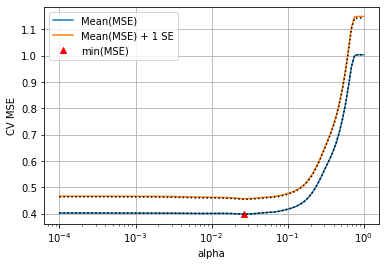

In [13]:
# Find the minimum MSE
imin = np.argmin(mse_cv)
alpha_min = alphas[imin]
mse_cv_lasso = mse_cv[imin]

# Plot the mean MSE, the minimum MSE, and the mean MSE + 1 std dev
plt.semilogx(alphas, mse_cv, label='Mean(MSE)')
plt.semilogx(alphas, mse_cv+mse_se, label='Mean(MSE) + 1 SE')
plt.semilogx(alpha_min, mse_cv_lasso, 'r^', label='min(MSE)')
plt.legend(loc='upper left')
plt.semilogx(alphas, mse_cv2,'k:')
plt.semilogx(alphas, mse_cv2+mse_se2,'k:')
plt.xlabel('alpha')
plt.ylabel('CV MSE')
plt.grid()
plt.show()

We now recompute LASSO using the full training data at the CV-MSE-minimizing alpha, and print out the coefficients. We do this two ways: the manual way (via `lasso.fit`), and using a shortcut (leveraging the fact that GridSearchCV has already computed these coefficients!).  As you can see, the results are identical.

In [14]:
# Refit LASSO using CV-tuned alpha
lasso.alpha = alpha_min
lasso.fit(Xtr,ytr)

# Print the coefficients
print("LASSO coefficients:")
print(" intrcpt %f" % lasso.intercept_)
for i, c in enumerate(lasso.coef_):
    print("%8s %f" % (names_x[i], c))
    
# Print the cross-validation MSE
print("\ncross-validation MSE = %f" % mse_cv_lasso)

LASSO coefficients:
 intrcpt 0.000000
  lcavol 0.519475
 lweight 0.206632
     age -0.064410
    lbph 0.083711
     svi 0.214407
     lcp -0.000000
 gleason 0.004616
   pgg45 0.057924

cross-validation MSE = 0.398888


In [15]:
# Shortcut using results of GridSearchCV
print('LASSO coefficients from GridSearchCV:')
print(" intrcpt %f" % gscv.best_estimator_.intercept_)
for i, c in enumerate(gscv.best_estimator_.coef_):
    print("%8s %f" % (names_x[i], c))
    
# Print the cross-validation MSE
print("\ncross-validation MSE = %f" % -gscv.best_score_)

LASSO coefficients from GridSearchCV:
 intrcpt 0.000000
  lcavol 0.519475
 lweight 0.206632
     age -0.064410
    lbph 0.083711
     svi 0.214407
     lcp -0.000000
 gleason 0.004616
   pgg45 0.057924

cross-validation MSE = 0.398888


From the final CV-MSE, you can see that the CV performance of LASSO is not great.  This is due to the shrinkage of the LASSO coefficient values.  

#### Debiasing LASSO

To circumvent the LASSO shrinkage issue, we perform *least-squares regression of the LASSO-selected coefficients*.  We'll call this method "LASSO+LS". Sometimes people refer to this approach as "debiasing" LASSO.

In [16]:
# Train LASSO-feature-selected LS on entire design data
nonzero = (np.abs(lasso.coef_)>1e-5) # logical array
subset = np.where(nonzero)[0] # array of feature indices

# Print the cross-validation MSE
scores = cross_val_score(linreg, Xtr[:, subset], ytr, cv=rkf, scoring='neg_mean_squared_error')
mse_cv_lasso_ls = -np.mean(scores)
print("cross-validation MSE = %f" % mse_cv_lasso_ls)

cross-validation MSE = 0.397190


We see that LASSO+LS performs much better than LASSO alone, but not as well as the optimal exhaustive search method.  One of the reasons for the suboptimal performance of the above LASSO+LS method is that it was not properly tuned.  Remember that we chose `alpha` to make the *shrunken* LASSO coefficients perform best, which is foolish because we later ignored those shrunken coefficient values!  Instead, we should select `alpha` so that the LASSO+LS coefficients perform best. In other words, we want to tune LASSO for best "debiased" performance.

### Tuning LASSO for best "debiased" performance using a `for` loop

To tune LASSO+LS, we will make a grid of `alpha` and fit a LASSO+LS model at every grid point. 
In particular, for each `alpha` value, we'll fit a LASSO model to the entire training data and identify the feature subset where the LASSO coefficients are non-zero. 
Then, using those features, we'll fit a least-squares model and evaluate the MSE using `cross_val_score`. 
First we'll implement this using a `for` loop.  

In [17]:
# compute the CV MSE of LASSO+LS over a grid of alpha
alphas = np.logspace(-2,-0.23,100)
mse_cv = np.zeros(len(alphas))
mse_se = np.zeros(len(alphas))
for i,a in enumerate(alphas):
    # fit LASSO
    lasso.set_params(alpha = a)
    lasso.fit(Xtr,ytr)
    # select features
    nonzero = (np.abs(lasso.coef_)>1e-5) # logical array
    subset = np.where(nonzero)[0] # array of feature indices
    # fit LS and evaluate performance using CV
    mse = -cross_val_score(linreg, Xtr[:, subset], ytr, cv=rkf, 
                                 scoring='neg_mean_squared_error')
    mse_cv[i] = np.mean(mse)
    mse_se[i] = np.std(mse,ddof=1) / np.sqrt(nfold)


From the cross-validation results, we can plot MSE versus `alpha` and extract the MSE-minimizing `alpha` as well as the minimized MSE.

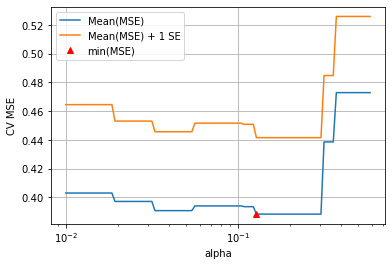

cross-validation MSE = 0.388373


In [18]:
# find MSE-minimizing alpha
imin = np.argmin(mse_cv)
alpha_min = alphas[imin]
mse_cv_lasso_ls1 = mse_cv[imin]

# Plot the mean MSE, the minimum MSE, and the mean MSE + 1 std dev
plt.semilogx(alphas, mse_cv, label='Mean(MSE)')
plt.semilogx(alphas, mse_cv+mse_se, label='Mean(MSE) + 1 SE')
plt.semilogx(alpha_min, mse_cv_lasso_ls1, 'r^', label='min(MSE)')
plt.legend(loc='upper left')
plt.xlabel('alpha')
plt.ylabel('CV MSE')
plt.grid()
plt.show()

# Print the cross-validation MSE
print("cross-validation MSE = %f" % mse_cv_lasso_ls1)

### Tuning LASSO+LS  using GridSearchCV and a pipeline

As we saw above, it is possible to tune LASSO for best "debiased" performance using a `for` loop. 
But we also know that sklearn's `GridSearchCV` provides an alternative to `for`-loop based cross-validation: it requires us to specify only the estimator, the parameter grid, the cross-val object, and the performance metric. 
But when the estimator is a cascade of operations like LASSO+FeatureSelection+LS, how do we pass it to `GridSearchCV`?
The answer is provided by sklearn's `Pipeline` framework, which allows one to cascade several estimators together.
In the pipeline, we can use sklearn's `SelectFromModel` transform to do the FeatureSelection step.

The code below first creates a pipeline with two steps: 1) LASSO followed by `SelectFromModel`, and 2) unregularized LS linear regression. 
We need to put `SelectFromModel` together with LASSO in one step because the former does not have a "fit" method, as is required for all components of a pipeline.
Once we build the pipeline, we can pass it into `GridSearchCV` as the estimator. 
We'll also pass in the same `alpha` grid, `kf` cross-validation object, and `neg_mean_squared_error` metric as before.

Note: if the `alpha` parameter grid contains values that cause LASSO to select zero features, the subsequent LS linear regression method will get confused and sklearn may throw an error. 
To avoid this, we set the largest `alpha` value in our grid so that LASSO selects at least one feature.

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# build pipeline for LASSO+FeatureSelect+LS
pipe = Pipeline([
  ('LASSO',SelectFromModel(linear_model.Lasso(fit_intercept=False,warm_start=False))),
  ('LS', linear_model.LinearRegression(fit_intercept=False))
])

# tune LASSO regularization strength
parameters = {'LASSO__estimator__alpha':alphas} # see pipe.get_params().keys()
gscv = GridSearchCV(pipe, parameters, cv=rkf, scoring='neg_mean_squared_error')
gscv.fit(Xtr,ytr);

From the cross-validation results, we can plot MSE versus `alpha` and extract the MSE-minimizing `alpha` as well as the minimized MSE.

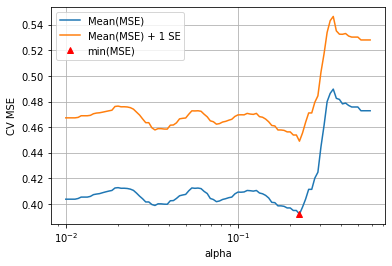

cross-validation MSE = 0.392121


In [20]:
mse_cv = -gscv.cv_results_['mean_test_score']
mse_se = gscv.cv_results_['std_test_score']/np.sqrt(nfold-1) # note division by (nfold-1)!

# Find the minimum MSE
imin = np.argmin(mse_cv)
alpha_min = alphas[imin]
mse_cv_lasso_ls2 = mse_cv[imin]

# Plot the mean MSE, the minimum MSE, and the mean MSE + 1 std dev
plt.semilogx(alphas, mse_cv, label='Mean(MSE)')
plt.semilogx(alphas, mse_cv+mse_se, label='Mean(MSE) + 1 SE')
plt.semilogx(alpha_min, mse_cv_lasso_ls2, 'r^', label='min(MSE)')
plt.legend(loc='upper left')
plt.xlabel('alpha')
plt.ylabel('CV MSE')
plt.grid()
plt.show()

print("cross-validation MSE = %f" % mse_cv_lasso_ls2)

Looking at the CV error-rates above, we can see that they are different from the ones computed by the `for`-loop method, even though we used the same estimator, k-fold method, and metric. 
This is because the two techniques differ slightly in *how* the LASSO stage is trained: 
In the `for`-loop method, LASSO is trained once using the full data, but in the pipeline method, LASSO is trained K times on different folds.
Because each fold can yield a different number of non-zero weights, the MSE curve is not piecewise constant as it was in the `for` loop method.
Furthermore, the pipeline method is slower to train because the most expensive stage (LASSO) is run K times more often.

Note that the above pipeline approach is performing a bit worse than the `for`-loop approach.
In an attempt to improve the pipeline results, we could apply the one-standard error (OSE) to choose `alpha` rather than choosing `alpha` as the CV-MSE minimizer.
Once we obtain this `alpha_ose`, we refit LASSO on the full training data, extract the selected features, and fit a LS linear model using only those features.
We do this below and find that the result has a CV MSE that matches the earlier `for`-loop approach.

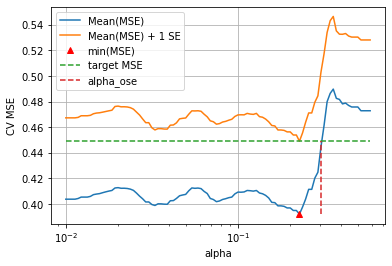

cross-validation MSE = 0.388373


In [21]:
# OSE rule: find the simplest model (largest alpha) whose MSE is below the target
mse_tgt = mse_cv[imin] + mse_se[imin]
I = np.where(mse_cv <= mse_tgt)[0]
iose = I[-1] # largest index => largest alpha
alpha_ose = alphas[iose]

# plot OSE approach
plt.semilogx(alphas, mse_cv, label='Mean(MSE)')
plt.semilogx(alphas, mse_cv+mse_se, label='Mean(MSE) + 1 SE')
plt.semilogx(alpha_min, mse_cv_lasso_ls2, 'r^', label='min(MSE)')
plt.semilogx([alphas[0],alphas[-1]], [mse_tgt,mse_tgt], '--', label='target MSE')
plt.semilogx([alpha_ose,alpha_ose], [np.min(mse_cv),mse_tgt], '--', label='alpha_ose')
plt.legend(loc='upper left')
plt.xlabel('alpha')
plt.ylabel('CV MSE')
plt.grid()
plt.show()

# now re-fit LASSO on the entire training data using alpha_ose
lasso.set_params(alpha = alpha_ose)
lasso.fit(Xtr,ytr)
# select features
nonzero = (np.abs(lasso.coef_)>1e-5) # logical array
subset = np.where(nonzero)[0] # array of feature indices
# fit LS on selected features and evaluate performance using CV
mse = -cross_val_score(linreg, Xtr[:, subset], ytr, cv=rkf, 
                            scoring='neg_mean_squared_error')
mse_cv_lasso_ls2_ose = np.mean(mse)

print("cross-validation MSE = %f" % mse_cv_lasso_ls2_ose)

##  Recursive feature elimination (RFE) with cross-validation

RFE is a "greedy" method to select features that recursively tries smaller and smaller subsets of features. It first performs linear regression with all features. Then it prunes the feature with the smallest coefficient and re-runs linear regression with the remaining features.  This procedure is repeated until one feature remains.  See http://scikit-learn.org/stable/modules/feature_selection.html#recursive-feature-elimination for details.

In [22]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=linreg, n_features_to_select=1)
rfe.fit(Xtr,ytr)

ranking = rfe.ranking_
print("ranking="+str(ranking))

ranking=[1 2 6 7 3 5 8 4]


The `ranking` vector shows the results of the greedy RFE procedure.  The feature with `ranking=1` is the most important feature, i.e., the one remaining after all others were pruned.  The feature with `ranking=2` is the second most important feature, and so on.

Although we RFE gives us a ranking, it does not tell us how *many* coefficients to use.  For that, we can use cross-validation, as implemented in the RFECV method.  Somehow the CV scores returned by `.grid_scores_` were not making sense, so below we manually perform CV to evaluate the MSE of the final result.  It works well!

In [41]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=linreg, cv=rkf, scoring='neg_mean_squared_error')
rfecv.fit(Xtr,ytr)

support = rfecv.support_ # logical array
subset = np.where(nonzero)[0] # array of feature indices

mse_cv_rfecv = -cross_val_score(linreg, Xtr[:,subset], ytr, cv=rkf, 
                           scoring='neg_mean_squared_error').mean()

print("best features = "+str(subset))
print("\ncross-validation MSE = "+str(mse_cv_rfecv))

best features = [0 1 4]

cross-validation MSE = 0.3883730978483264


Below, we attempted to manually code the RFECV procedure, in order to see how the feature set is pruned and how the resulting MSE changes.  Strangely, our implementation does not agree with RFECV, and in fact works better!

In [24]:
# manual implementation of RFECV
features = []
mse_cv = []

# first perform linear regression on full feature set
feat = np.arange(0,nfeatures) # list of features
features.append(feat)
mse = -cross_val_score(linreg, Xtr[:,feat], ytr, cv=rkf, 
                         scoring='neg_mean_squared_error').mean()
mse_cv.append(mse)
print("feat="+str(feat),", mse="+str(mse_cv[-1]))

# recursively remove feature with weakest coefficient 
for i in range(0,nfeatures-1): # number of features to remove
    linreg.fit(Xtr[:,feat],ytr) # linear regression
    iomit = np.argmin(np.abs(linreg.coef_)) # index of smallest coefficient
    nf = feat.size # length of feat
    indx = np.r_[ np.r_[0:iomit],np.r_[iomit+1:nf] ] # indices of feat after pruning
    feat = feat[indx] # new list of features
    features.append(feat)
    mse = -cross_val_score(linreg, Xtr[:,feat], ytr, cv=rkf, 
                           scoring='neg_mean_squared_error').mean()
    mse_cv.append(mse)
    print("feat="+str(feat),", mse="+str(mse_cv[-1]))

imin = np.argmin(mse_cv)
mse_cv_rfecv = mse_cv[imin]
feat_min = features[imin]

print("")
print("best features = "+str(feat_min))
print("\ncross-validation MSE = "+str(mse_cv_rfecv))

feat=[0 1 2 3 4 5 6 7] , mse=0.4030480793193428
feat=[0 1 2 3 4 5 7] , mse=0.39646734095227176
feat=[0 1 2 4 5 7] , mse=0.4000644821098867
feat=[0 1 4 5 7] , mse=0.40276131052229425
feat=[0 1 4 7] , mse=0.3935570530935449
feat=[0 1 4] , mse=0.3883730978483264
feat=[0 1] , mse=0.4234934618411058
feat=[0] , mse=0.47286983169371466

best features = [0 1 4]

cross-validation MSE = 0.3883730978483264


## Feature selection via mutual information

Let's try ranking feaures based on mutual information with the target.  We'll then use cross-validation to choose how many of the top-ranked features to use.

In [25]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# first, rank coefficients
selector = SelectKBest(score_func=mutual_info_regression, k='all')
selector.fit(Xtr, ytr)
ranking = np.argsort(-selector.scores_)+1
print("ranking="+str(ranking))

# next use CV to choose how many coefficients
se_cv = np.zeros(nfeatures)
mse_se = np.zeros(nfeatures)
nselect = np.arange(nfeatures)+1
for r in nselect:
    subset = np.where(ranking<=r)[0]
    scores = cross_val_score(linreg, Xtr[:,subset], ytr, cv=rkf, scoring='neg_mean_squared_error')
    mse_cv[r-1] = -np.mean(scores)
    mse_se[r-1] = np.std(scores,ddof=1) / np.sqrt(nfold)
    print("feat="+str(subset),", mse="+str(mse_cv[r-1]))
    
# Find the model order yielding minimum CV MSE
nselect_min = np.argmin(mse_cv)+1
mse_cv_rfemi = mse_cv[nselect_min-1]

# Print the cross-validation MSE
print("\ncross-validation MSE = %f" % mse_cv_rfemi)

ranking=[1 5 6 7 8 2 4 3]
feat=[0] , mse=0.47286983169371466
feat=[0 5] , mse=0.47977516293351286
feat=[0 5 7] , mse=0.4854361493291335
feat=[0 5 6 7] , mse=0.491663091761986
feat=[0 1 5 6 7] , mse=0.44136420190057735
feat=[0 1 2 5 6 7] , mse=0.43871402828328876
feat=[0 1 2 3 5 6 7] , mse=0.44064923877666784
feat=[0 1 2 3 4 5 6 7] , mse=0.4030480793193428

cross-validation MSE = 0.403048


## Ridge regression

Finally we try ridge regression. Although we know that it does not perform feature selection, we're still curious to see how well it works on this dataset.  We'll use cross-validation to find the MSE-minimizing value of the regularization parameter `alpha`.

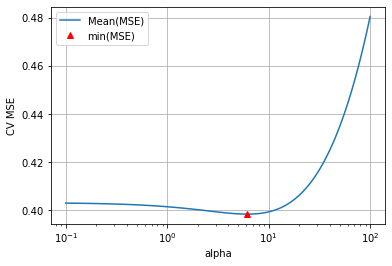

Ridge:
 intrcpt 0.000000
  lcavol 0.511004
 lweight 0.225234
     age -0.111289
    lbph 0.109480
     svi 0.248974
     lcp -0.056588
 gleason 0.039091
   pgg45 0.085659

cross-validation MSE = 0.398266


In [26]:
# Ridge model
ridge = linear_model.Ridge(fit_intercept=False)

# Regularization values to test
nalpha = 100
alphas = np.logspace(-1,2,nalpha)
param_grid = {'alpha': alphas}

# Run cross-validation
gscv = GridSearchCV(ridge, param_grid, cv=rkf, scoring='neg_mean_squared_error')
gscv.fit(Xtr,ytr)
mse_cv = -gscv.cv_results_['mean_test_score']

# Find the minimum MSE
imin = np.argmin(mse_cv)
alpha_min = alphas[imin]
mse_cv_ridge = mse_cv[imin]

# Plot performance versus alpha
plt.semilogx(alphas, mse_cv, label='Mean(MSE)')
plt.semilogx(alpha_min, mse_cv_ridge, 'r^', label='min(MSE)')
plt.legend(loc='upper left')
plt.xlabel('alpha')
plt.ylabel('CV MSE')
plt.grid()
plt.show()

# Print the coefficients
print('Ridge:')
print(" intrcpt %f" % gscv.best_estimator_.intercept_)
for i, c in enumerate(gscv.best_estimator_.coef_):
    print("%8s %f" % (names_x[i], c))

# # Evaluate best model on the validation fold
# yval_pred = gscv.best_estimator_.predict(Xval)
# mse_val_ridge = np.mean((yval_pred-yval)**2)

# # Print the validation MSE
# print("\nvalidation MSE = %f" % mse_val_ridge)

# Print the cross-validation MSE
print("\ncross-validation MSE = %f" % mse_cv_ridge)

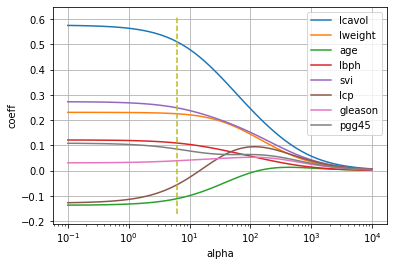

In [27]:
# Compute the ridge coefficient path
nalpha = 100
alphas = np.logspace(-1,4,nalpha)
coeffs = []
for a in alphas:
    ridge.alpha = a
    ridge.fit(Xtr, ytr)
    coeffs.append(ridge.coef_)

# Plot the paths of the coefficients
plt.semilogx(alphas,coeffs)
plt.grid()
xmin, xmax, ymin, ymax = plt.axis()
#plt.axis([xmin,np.exp(np.log(xmax)+0.25*(np.log(xmax)-np.log(xmin))),ymin,ymax])
plt.legend(names_x, loc='upper right')

# Plot a line on the OSE alpha
plt.semilogx([alpha_min,alpha_min], [ymin,ymax], '--')
plt.xlabel('alpha')
plt.ylabel('coeff')
plt.show()

## Summary and discussion

We now summarize the CV-MSE for all methods considered in this demo

In [28]:
# Summary
print("cross-validation MSE:")
print("  LS = %f" % mse_cv_ls)
print("  Ridge = %f" % mse_cv_ridge)
print("  LASSO = %f" % mse_cv_lasso)
print("  LASSO(debiased) = %f" % mse_cv_lasso_ls)
print("  LASSO+LS(for)= %f" % mse_cv_lasso_ls1)
print("  LASSO+LS(pipe)= %f" % mse_cv_lasso_ls2_ose)
print("  RFE-CV+LS = %f" % mse_cv_rfecv)
print("  RFE-MI+LS = %f" % mse_cv_rfemi)
print("  exhaustive+LS = %f" % mse_cv_exhaustive)

cross-validation MSE:
  LS = 0.403048
  Ridge = 0.398266
  LASSO = 0.398888
  LASSO(debiased) = 0.397190
  LASSO+LS(for)= 0.388373
  LASSO+LS(pipe)= 0.388373
  RFE-CV+LS = 0.388373
  RFE-MI+LS = 0.403048
  exhaustive+LS = 0.388072


When looking at the cross-validation results, we see the expected trends:
* exhaustive feature selection gives the best performance, since it is the optimal method
* no feature selection (i.e., ordinary LS) gives relatively poor performance
* ridge regression is only slightly better than ordinary LS
* LASSO is only slightly better than ordinary LS
* LASSO+LS gets close to exhaustive feature selection
* RFE-CV+LS gets close exhaustive selection